In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
%matplotlib inline

In [3]:
# define function to initialize "pretty" plots
def define_figure(xlabel="X",ylabel="Y"):
    # setup plot parameters
    fig = plt.figure(figsize=(10,8), dpi= 80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    ax.grid(b=True, which='major', axis='both', color='#808080', linestyle='--')
    ax.set_xlabel(xlabel,size=20)
    ax.set_ylabel(ylabel,size=20)
    plt.tick_params(axis='both',labelsize=20)
    return ax

1.  The Morse potential is a reasonably good description of a bond potential for a diatomic molecule.  This potential is given as $U(r) = D_e\left(1-e^{-\beta (r-r_e)}\right)^2$ where $D_e$ is the dissocation energy, $\beta$ is related to the curvature of the potential near the minimum and $r_e$ is the equilibrium bond length.  An alternative description of a bond potential is the Lennard-Jones potential given as $U(r) = 4\epsilon\left[\left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6\right]$ where $\epsilon$ is related to the well depth of the potential and $\sigma$ is the separation distance at which the potential is equal to zero.  For an HF molecule, parameters for the Morse potential are $D_e = 0.4891265$ Rydberg, $\beta=1.208173$ Bohr$^{-1}$, and $r_e = 1.7322534$ Bohr.  

    1. Determine the linear least square values for the LJ potential that best fits the Morse potential for HF using the parameters given.
    
    2. Determine the first three vibrational energy levels (numeric values in units of $\hbar$) for both potentials.  Compare these to the Harmonic Oscillator solutions.  Make sure to state any assumptions or approximations used to solve for these.
    
    3. Make a plot of the potentials as a function of $r$.  Include the first three energy levels and wavefunctions.  
    
    4.  Compute the transition dipole moments in the Harmonic Oscillator approximation, Morse and Lennard-Jones Hamiltonians for the $0\rightarrow0$, $0\rightarrow1$, $0\rightarrow2$ and $1\rightarrow2$ transitions.   What does this suggest about the selection rules for each oscillator?

***Most of you were able to do 1A just fine.  We will thus start by determining the vibrational levels for the Morse potential.***

## Morse Oscillator in Variational Approach

In [57]:
# code to perform Variational principle solution to expansion of wavefunctions in a gaussian basis to K+V Hamiltonian in 1D
# define necessary units for kinetic energy
hbar = 1.0
mu = 1.6726219E4/9.11

def gaussian_integrand(x,V,xi,xj,alpha):
    return np.exp(-alpha*(x-xi)**2)*V(x)*np.exp(-alpha*(x-xj)**2)

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def gaussian_basis_variational(N,V,xvals=np.arange(-4,4,0.1),dx=0.1):
    #N = 3                       # half the number of basis functions
    K = 2*N+1                    # total number of basis functions
    alpha = 4.0/dx                 # 1/spread of basis functions
    xmin = -N*dx                 # minimum x value for basis functions
    xIntegrand = np.arange(xmin-1.0/alpha*10,N*dx+1.0/alpha*10,0.001)
    S = np.zeros((K,K),dtype=np.float64)   # basis function overlap matrix
    H = np.zeros((K,K),dtype=np.float64)   # Hamiltonian matrix, Hij = <Si|H|Sj>

    # populate the basis function, S, and Hamiltonian, H, matrices
    for i in range(K):
        xi = xmin + (i-1)*dx
        for j in range(i,K):
            xj = xmin + (j-1)*dx
            # basis function value:
            # Ostlund and Szabo page 47
            S[i,j] = np.sqrt(0.5*np.pi/alpha)*np.exp(-0.5*alpha*(xi-xj)**2)
            # Hamiltonian value (standard Harmonic Oscillator matrix element - applied to basis functions)
            H[i,j] = 0.5/mu*S[i,j]*(alpha - (alpha**2)*(xi-xj)**2) # Kinetic energy
#            H[i,j] += integrate.quad(integrand,-np.inf,np.inf,args=(V,xi,xj,alpha))[0] # potential energy using numeric integration
            H[i,j] += integrate.simps(gaussian_integrand(xIntegrand,V,xi,xj,alpha),xIntegrand)
            S[j,i] = S[i,j]
            H[j,i] = H[i,j]
    # finalize the S^-1*H matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these so largest eigenvalue is first
    idx = H_eig_val.argsort()   
    H_eig_val = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]

    nx = xvals.size
    psi = np.zeros((nx,K),dtype=np.float64)
    psiNorm = np.empty(xIntegrand.size,dtype=np.float64)
    # generate psis from coefficients
    for A in range(K):
        count = K-A-1
        psiNorm = 0.0
        for i in range(K):
            xi = xmin + (i-1)*dx
            psi[:,A] = psi[:,A] + H_eig_vec[i,A]*np.exp(-alpha*(xvals-xi)**2)
            psiNorm = psiNorm + H_eig_vec[i,A]*np.exp(-alpha*(xIntegrand-xi)**2)
    
        # normalize the wavefunctions
        psi2 = np.power(psiNorm,2)
        norm = np.float64(integrate.simps(psi2,xIntegrand))
        psi[:,A] /= np.sqrt(norm)
    # return normalized wavefunctions and energies
    return psi, H_eig_val

***There are analytic solutions to the Morse Oscillator.  The energy levels are fairly simple so we will use those to compare against.***

In [12]:
# morse analytic solutions in atomic units - can look up in Wikipedia
De = 0.4891265/2.0 # Rydberg to Hartree
re = 1.7322534 # Bohr
beta = 1.208173 # Bohr^-1
massH = 1.6726219E-27/9.10938356E-31  # mass in me
massF = 19*1.6726219E-27/9.10938356E-31   # mass in me
mu = massH*massF/(massH+massF)  # reduced mass
hbar = 1. # atomic units

w0 = np.sqrt(2*De/mu)*beta
xe = hbar*w0/(4*De)

def morse_energy_levels(n):
#    return (lambda_m**2-(lambda_m-n-0.5)**2)*beta**2/2.
    return hbar*w0*((n+0.5)-xe*(n+0.5)**2)


for i in range(0,25):
    print i, morse_energy_levels(i) 

0 0.010011042812162257
1 0.029405522388378028
2 0.047963193900448814
3 0.06568405734837461
4 0.08256811273215542
5 0.09861536005179122
6 0.11382579930728205
7 0.1281994304986279
8 0.14173625362582873
9 0.1544362686888846
10 0.16629947568779546
11 0.17732587462256136
12 0.18751546549318224
13 0.19686824829965816
14 0.20538422304198906
15 0.21306338972017497
16 0.21990574833421592
17 0.22591129888411182
18 0.2310800413698628
19 0.23541197579146875
20 0.23890710214892977
21 0.24156542044224572
22 0.24338693067141676
23 0.24437163283644273
24 0.24451952693732373


In [13]:
# perform variational solution for Morse oscillator using displacement coordinate
# define morse potential
def morse(x):
    return De*(1-np.exp(-beta*x))**2

# check for convergence
for i in range(10,20):
    psi_morse, E_morse = gaussian_basis_variational(i,morse)
    print i, E_morse[0:6]

10 [0.01001104 0.02940552 0.0479632  0.06568407 0.0825684  0.09862343]
11 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256815 0.098616  ]
12 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861549]
13 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
14 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
15 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
16 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
17 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
18 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]
19 [0.01001104 0.02940552 0.0479632  0.06568407 0.08256813 0.09861545]


***Note that the Variational solutions converge and are almost identical to the analytic solutions.***

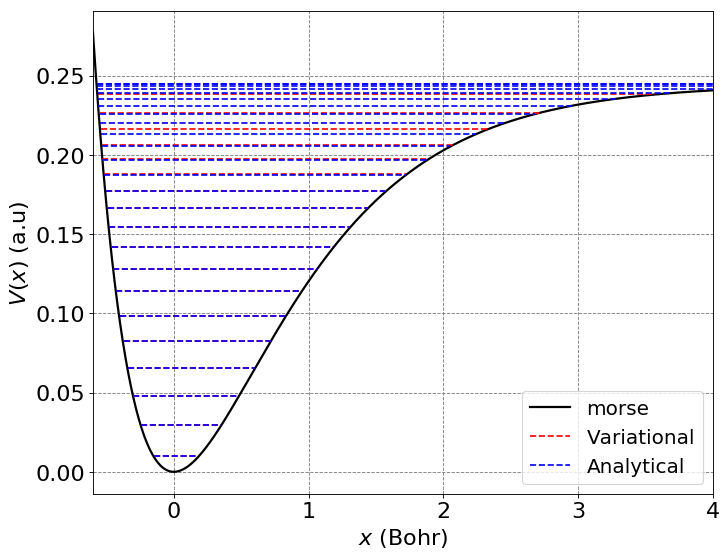

In [17]:
# graph solutions
ax = define_figure(xlabel="$x$ (Bohr)",ylabel="$V(x)$ (a.u)")
xvals = np.arange(-0.6,6,0.01)
U_morse = morse(xvals)
psi_morse, E_morse = gaussian_basis_variational(20,morse,xvals)
# plot potential energies
ax.plot(xvals, U_morse, 'k',lw=2,label="morse")
# plot morse energy levels and wavefunctions
for n in range(25):
    # variational 
    if (E_morse[n] <= De):
        # plot the energy level
        mask = np.where(E_morse[n] > U_morse)
        if n==0:
            ax.plot(xvals[mask], E_morse[n] * np.ones(np.shape(xvals))[mask], 'r--',label="Variational")
        else:
            ax.plot(xvals[mask], E_morse[n] * np.ones(np.shape(xvals))[mask], 'r--')
    if (morse_energy_levels(n) <= De):
        # plot the energy level
        mask = np.where(morse_energy_levels(n) > U_morse)  
        if n==0:
            ax.plot(xvals[mask], morse_energy_levels(n) * np.ones(np.shape(xvals))[mask], 'b--',label="Analytical")
        else:
            ax.plot(xvals[mask], morse_energy_levels(n) * np.ones(np.shape(xvals))[mask], 'b--')
        
ax.set_xlim(-0.6, 4)
#ax.set_ylim(0, 25)
ax.legend(loc=4,fontsize=18)

***We see good agreement between the Variational solutions and the Analytic solutions to the Morse Oscillator for energy levels not near the dissociation limit.  Certainly the first three demonstrate excellent agreement and thus we can be confident in using the variational wavefunctions.***

## Lennard-Jones Oscillator in Variational Approach

In [78]:
# code to perform Variational principle solution in a defined basis
hbar = 1.0
mass = 1.6726219E4/9.11
def lj_basis(x,xi,alpha):
    return x**(12)*np.exp(-alpha*(x-xi)**2)

# integrand for potential component of Hamiltonian matrix element for gaussian basis functions
def lj_integrand(x,V,i,xi,j,xj,alpha,norm):
    return lj_basis(x,xi,alpha)/norm[i]*V(x)*lj_basis(x,xj,alpha)/norm[j]

# variational principle basis set solution for KE plus V (typically harmonic) - basis functions are guassians
def lj_basis_variational(N,V,xvals=np.arange(0,10,0.1),dx=0.1):
    alpha = 4.0/dx               # 1/spread of gaussians in basis functions
    thresh = 0.0001
    xmin = dx                    # minimum x value for basis functions
    xmax = xmin+(N-2)*dx
    xIntegrand = np.arange(0.01,xmax+50,0.001)
    S = np.zeros((N,N),dtype=np.float64)   # basis function overlap matrix
    H = np.zeros((N,N),dtype=np.float64)   # Hamiltonian matrix, Hij = <Si|H|Sj>
    norm = np.empty(N,dtype=np.float64)
    # populate the basis function, S, and Hamiltonian, H, matrices
    for i in range(N):
        xi = xmin + (i-1)*dx
        norm[i] = integrate.simps(lj_basis(xIntegrand,xi,alpha),xIntegrand)
    for i in range(N):
        xi = xmin + (i-1)*dx
        for j in range(i,N):
            xj = xmin + (j-1)*dx
            # Basis set overlap matrix elements
            S[i,j] = integrate.simps(lj_basis(xIntegrand,xi,alpha)/norm[i]*lj_basis(xIntegrand,xj,alpha)/norm[j],xIntegrand)
            # Hamiltonian Matrix Elements
            H[i,j] = -0.5*hbar/mass*integrate.simps(lj_basis(xIntegrand,xi,alpha)/norm[i]*np.gradient(np.gradient(lj_basis(xIntegrand,xj,alpha)/norm[j],0.001),0.001),xIntegrand) # Kinetic energy
            H[i,j] += integrate.simps(lj_integrand(xIntegrand,V,i,xi,j,xj,alpha,norm),xIntegrand)
            # symmetrize the two matrices
            S[j,i] = S[i,j]
            H[j,i] = H[i,j]
    # finalize the S^-1*H matrix
    SinvH = np.dot(np.linalg.inv(S),H)
    # compute eigenvalues and eigenvectors
    H_eig_val, H_eig_vec = np.linalg.eig(SinvH)
    # reorder these so largest eigenvalue is first
    idx = H_eig_val.argsort()   
    H_eig_val = H_eig_val[idx]
    H_eig_vec = H_eig_vec[:,idx]

    nx = xvals.size
    psi = np.zeros((nx,N),dtype=np.float64)
    psiNorm = np.empty(xIntegrand.size,dtype=np.float64)
    # generate psis from coefficients
    for A in range(N):
        psiNorm = 0.0
        for i in range(N):
            xi = xmin + (i-1)*dx
            psi[:,A] = psi[:,A] + H_eig_vec[i,A]*np.exp(-alpha*(xvals-xi)**2)
            psiNorm = psiNorm + H_eig_vec[i,A]*np.exp(-alpha*(xIntegrand-xi)**2)
    
        # normalize the wavefunctions
        psi2 = np.power(psiNorm,2)
        norm = np.float64(integrate.simps(psi2,xIntegrand))
        psi[:,A] /= np.sqrt(norm)
    # return normalized wavefunctions and energies
    return psi, H_eig_val

Since the Lennard-Jones potential is defined for $r>0$, we must choose  basis functions that satisfy these boundary conditions.  I choose (not unique) to use basis functions of the form

$g_i(r) = r^{12}e^{-\alpha(r-r_i)^2}$.

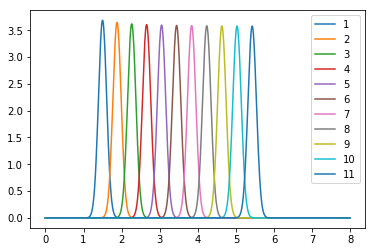

In [77]:
from scipy.special import factorial

def lj_basis(x,i,xi,alpha):
    return x**(12)*np.exp(-alpha*(x-xi)**2)

x =np.arange(0,8,0.01)
xmin = 1.0
dx = 0.1
alpha = 4.0/dx

for i in range(1,12):
    xi = xmin + delta*i
    norm = integrate.simps(np.power(lj_basis(x,i,xi,alpha),1),x)
    plt.plot(x,lj_basis(x,i,xi,alpha)/norm,label=str(i))
plt.legend()

In [115]:
# Define Lennard-Jones potential and perform variational solutions in this basis
epsilon = De
sigma = re/2.0**(1.0/6.0)

def lj(x):
    return 4*epsilon*( (sigma/x)**12 - (sigma/x)**6 )

for i in range(30,40):
    psi, E = lj_basis_variational(i,lj,xvals=np.arange(0.01,10,0.01),dx=0.05)
    print "Ground state energy for i=", i, " is:", E[0]

Ground state energy for i= 30  is: -0.06925211774179937
Ground state energy for i= 31  is: -0.14567733305332164
Ground state energy for i= 32  is: -0.18489548875697853
Ground state energy for i= 33  is: -0.20393311245804288
Ground state energy for i= 34  is: -0.21210306045091779
Ground state energy for i= 35  is: -0.21577061310260023
Ground state energy for i= 36  is: -0.21688737722854878
Ground state energy for i= 37  is: -0.2172021179094763
Ground state energy for i= 38  is: -0.21724676538820464
Ground state energy for i= 39  is: -0.21723182382453174


In [113]:
psi_lj, E_lj = lj_basis_variational(50,lj,xvals=np.arange(0.01,10,0.01),dx=0.05)
print E_lj[:10]

[-0.21724243 -0.16871548 -0.12771188 -0.09370615 -0.06614148 -0.04354466
 -0.02158797  0.00505218  0.03575142  0.07186528]


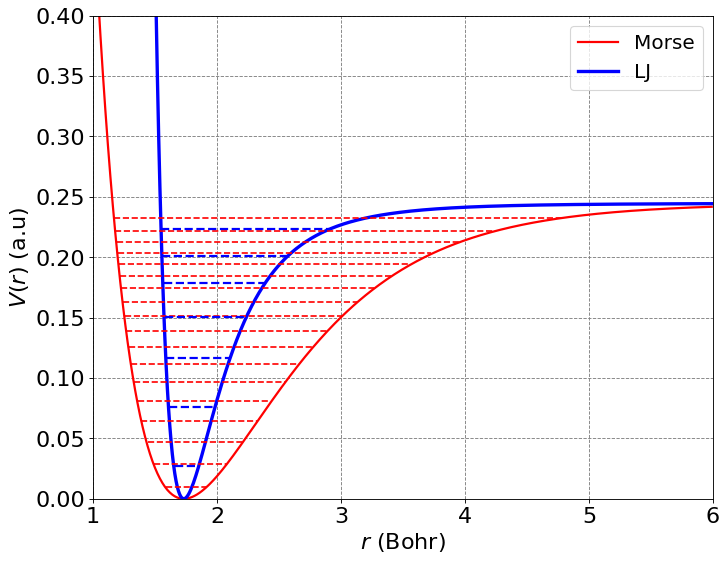

In [117]:
# graph solutions to both the Morse and LJ Oscillators
ax = define_figure(xlabel="$r$ (Bohr)",ylabel="$V(r)$ (a.u)")
xvals = np.arange(1.0,6,0.01)
U_morse = morse(xvals-re)
U_lj = lj(xvals)+De
psi_morse, E_morse = gaussian_basis_variational(20,morse,xvals)
# plot potential energies
ax.plot(xvals, U_morse, 'r',lw=2,label="Morse")
ax.plot(xvals,U_lj,'b',lw=3,label="LJ")
# plot morse energy levels and wavefunctions
for n in range(25):
    # variational 
    if (E_morse[n] <= De):
        # plot the energy level
        mask = np.where(E_morse[n] > U_morse)
        ax.plot(xvals[mask], E_morse[n] * np.ones(np.shape(xvals))[mask], 'r--')
for n in range(7):
    if (E_lj[n]+De <= De):
        # plot the energy level
        mask = np.where(E_lj[n]+De > U_lj)  
        ax.plot(xvals[mask], (E_lj[n]+De) * np.ones(np.shape(xvals))[mask], 'b--',lw=2)
        
ax.set_xlim(1.0, 6)
ax.set_ylim(0, 0.4)
ax.legend(fontsize=18)

(1.0, 3)

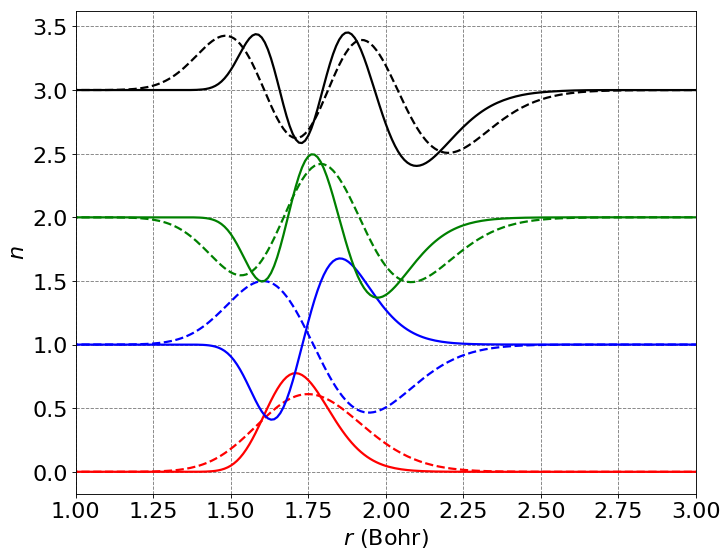

In [120]:
# graph wavefunctions to both the Morse and LJ Oscillators
ax = define_figure(xlabel="$r$ (Bohr)",ylabel="$n$")
color = ['r', 'b', 'g', 'k', 'm']
x = np.arange(0.01,10,0.01)
psi_morse, E_morse = gaussian_basis_variational(20,morse,x-re)
for n in range(4):
    plt.plot(x,psi_lj[:,n]/3.0+n,lw=2,color=color[n],ls='-')
    plt.plot(x,psi_morse[:,n]/3.0+n,lw=2,color=color[n],ls='--')
ax.set_xlim(1.0, 3)

(1.0, 3)

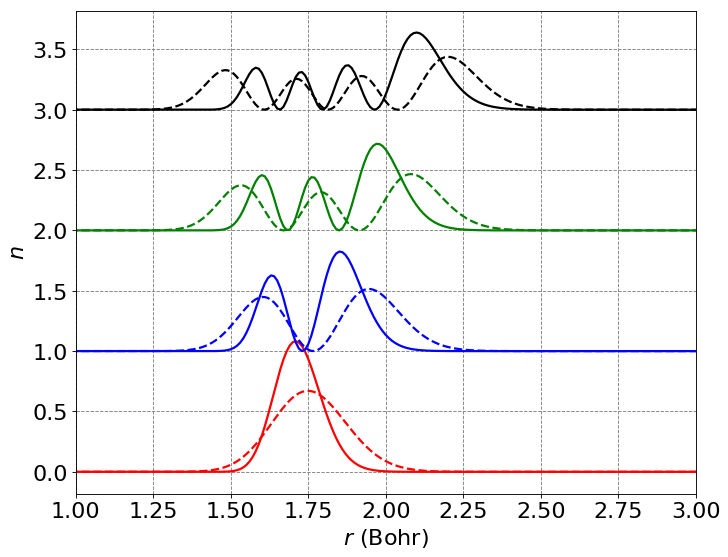

In [121]:
# graph probabilities to both the Morse and LJ Oscillators
ax = define_figure(xlabel="$r$ (Bohr)",ylabel="$n$")
color = ['r', 'b', 'g', 'k', 'm']
for n in range(4):
    plt.plot(x,np.power(psi_lj[:,n],2)/5.0+n,lw=2,color=color[n],ls='-')
    plt.plot(x,np.power(psi_morse[:,n],2)/5.0+n,lw=2,color=color[n],ls='--')
ax.set_xlim(1.0, 3)

## Transition Dipole Moments

In [88]:
x = np.arange(0.001,10,0.001)
psi_lj, E_lj = lj_basis_variational(50,lj,x,dx=0.05)
xmorse = np.arange(-10,10,0.001)
psi_morse, E_morse = gaussian_basis_variational(20,morse,xmorse)
print("Lennard-Jones:")
for i in range(4):
    for j in range(i,4):
        lj_trans_dipole = integrate.simps(psi_lj[:,i]*(x-re)*psi_lj[:,j],x)
        chars = "<" + str(i) + "|x|" + str(j) + "> = "
        print(chars,lj_trans_dipole)
print("Morse:")
for i in range(4):
    for j in range(i,4):
        morse_trans_dipole = integrate.simps(psi_morse[:,i]*xmorse*psi_morse[:,j],xmorse)
        chars = "<" + str(i) + "|x|" + str(j) + "> = "
        print(chars,morse_trans_dipole)

Lennard-Jones:
('<0|x|0> = ', -0.012215141674944842)
('<0|x|1> = ', 0.0729392393306435)
('<0|x|2> = ', 0.01516902675385533)
('<0|x|3> = ', -0.004866118921053432)
('<1|x|1> = ', 0.05599048340457726)
('<1|x|2> = ', -0.10614284455076597)
('<1|x|3> = ', 0.027631174457900982)
('<2|x|2> = ', 0.13481051730361082)
('<2|x|3> = ', 0.1340930852271382)
('<3|x|3> = ', 0.22774092081194675)
Morse:
('<0|x|0> = ', 0.0253984033985335)
('<0|x|1> = ', -0.11869200076066158)
('<0|x|2> = ', 0.012155210604994955)
('<0|x|3> = ', -0.002053344965321423)
('<1|x|1> = ', 0.07792845218236197)
('<1|x|2> = ', 0.1696062088133496)
('<1|x|3> = ', -0.021498640855417042)
('<2|x|2> = ', 0.13315263662523097)
('<2|x|3> = ', 0.20993619509724937)
('<3|x|3> = ', 0.1913356532372551)


## Moments of Inertia

***2C*** In order to compute $\langle I \rangle_\nu$ we must evaluate$\langle r^2\rangle_\nu$ 

In [110]:
print("Lennard-Jones:")
for i in range(4):
    lj_trans_dipole = integrate.simps(psi_lj[:,i]*np.power(x,2)*psi_lj[:,i],x)
    chars = "<" + str(i) + "|r^2|" + str(i) + "> = "
    print(chars,lj_trans_dipole)
print("Morse:")
for i in range(4):
    morse_trans_dipole = integrate.simps(psi_morse[:,i]*np.power(xmorse+re,2)*psi_morse[:,i],xmorse)
    chars = "<" + str(i) + "|r^2|" + str(i) + "> = "
    print(chars,morse_trans_dipole)

Lennard-Jones:
('<0|r^2|0> = ', 2.9640968261238347)
('<1|r^2|1> = ', 3.215451536782789)
('<2|r^2|2> = ', 3.5181532553535972)
('<3|r^2|3> = ', 3.8917686220722825)
Morse:
('<0|r^2|0> = ', 3.1035798420257663)
('<1|r^2|1> = ', 3.3200937940415542)
('<2|r^2|2> = ', 3.5537437061833)
('<3|r^2|3> = ', 3.8065771764515284)
